In [181]:
import pandas as pd
import datetime

treshold = 10
fee = 1.5
delta = 0.95

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [182]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [183]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [184]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [185]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [186]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [187]:
# gold_cot[(gold_cot['Prod_net_position_perc'] == 1.0) | (gold_cot['Money_manager_net_position_perc'] == 1.0)][['Money_manager_net_position_perc', 'Prod_net_position_perc']]

In [188]:
def create_labels(df):
    global fee, treshold, delta
    def calculate_target(row):
        volatility = row*delta
        if abs(volatility) > fee + treshold:
            if volatility > 0:
                return 1
            else:
                return (-1)
        else:
            return 0

    df['target'] = df['Settle'] - df['Open']
    df['target'] = df['target'].map(calculate_target)
    df.target = df.target.shift(-1)
    return df

In [189]:
gold = create_labels(gold)
tot, trade = gold.shape[0], gold[gold.target != 0].shape[0]
print(tot, trade, float(trade/tot))

5781 773 0.13371389033039266


In [190]:
corn = create_labels(corn)
tot, trade = corn.shape[0], corn[corn.target != 0].shape[0]
print(tot, trade, float(trade/tot))

5790 393 0.06787564766839378


In [191]:
treshold = 3
coffee = create_labels(coffee)
tot, trade = coffee.shape[0], coffee[coffee.target != 0].shape[0]
print(tot, trade, float(trade/tot))

5752 451 0.07840751043115438


In [192]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,1.0
1996-01-25,110.30,111.90,109.60,111.75,5915.0,14721.0,1.0
1996-01-26,110.00,117.50,109.70,116.95,9732.0,14641.0,1.0
1996-01-30,122.20,123.00,119.00,119.55,6931.0,14090.0,1.0
1996-02-09,124.50,127.20,124.50,126.05,4373.0,10734.0,-1.0
1996-02-22,123.50,124.40,122.05,122.30,4526.0,16221.0,-1.0
1996-03-28,122.50,123.00,120.40,121.40,4874.0,17693.0,-1.0


In [193]:
# from itertools import count
import numpy as np


def create_vectors(df, df_cot):
    global trading_days_in_year
    
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:(df.shape[1]-1)].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        mtrx = mtrx + mtrx_cot
        mtrx.append(df.iloc[i, df.shape[1]-1])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [194]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]

In [195]:
gold_data.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040
2018-12-14,1159.8,1168.0,1140.0,1163.7,206337.0,272962.0,1143.8,1146.0,1124.3,1129.8,...,0.087364,0.916625,0.162104,0.957183,0.139100,0.859876,0.275776,0.795660,0.307822,0.0
2018-12-17,1143.8,1146.0,1124.3,1129.8,264010.0,278134.0,1130.5,1143.2,1128.5,1137.4,...,0.087364,0.916625,0.162104,0.957183,0.139100,0.859876,0.275776,0.795660,0.307822,0.0
2018-12-18,1130.5,1143.2,1128.5,1137.4,173977.0,278036.0,1136.1,1144.4,1135.5,1142.7,...,0.087364,0.916625,0.162104,0.957183,0.139100,0.859876,0.275776,0.795660,0.307822,0.0
2018-12-19,1136.1,1144.4,1135.5,1142.7,112908.0,277461.0,1139.8,1141.7,1127.3,1133.6,...,0.162104,0.957183,0.139100,0.859876,0.275776,0.795660,0.307822,0.808471,0.346733,1.0
2018-12-20,1139.8,1141.7,1127.3,1133.6,138335.0,277398.0,1134.0,1138.8,1131.0,1133.2,...,0.162104,0.957183,0.139100,0.859876,0.275776,0.795660,0.307822,0.808471,0.346733,0.0


In [196]:
gold_data.shape

(5276, 3041)

In [253]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

gold_validate = gold_data.loc['2016-01-01' <= gold_data.index]
gold_data_tt = gold_data.loc['2016-01-01' > gold_data.index]
gold_train, gold_test, label_train, label_test = train_test_split(gold_data_tt[list(range(3025-1))], gold_data_tt[3040], test_size=0.2, random_state=2242)

# pca = PCA(n_components='mle', random_state=2234)
pca = PCA(n_components=5, random_state=2234)
pca.fit(gold_train)

gold_train_pca = pca.transform(gold_train)
print(gold_train_pca.size)

18105


In [254]:
import matplotlib.pyplot as plt

def plot_pca_relation(pca_data, x, y):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    # plt.plot(x, y)
    # plt.yscale('linear')
    # plt.title('linear')
    for i in range(x):
        for j in range(y):
            if i == j:
                continue
            # plt.subplot(221)
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in np.unique(labels):
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()
            # plt.grid(True)

<Figure size 432x288 with 0 Axes>

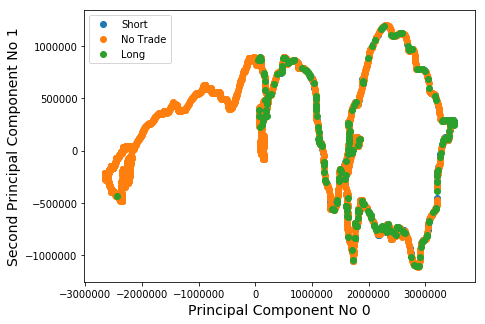

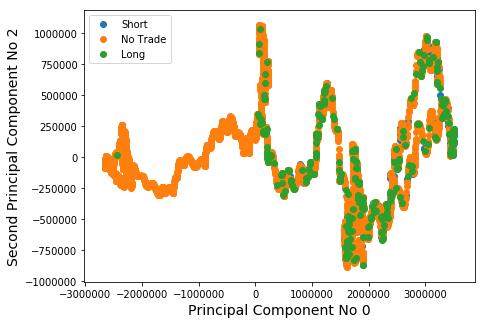

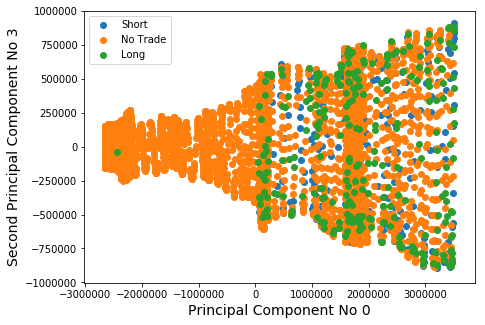

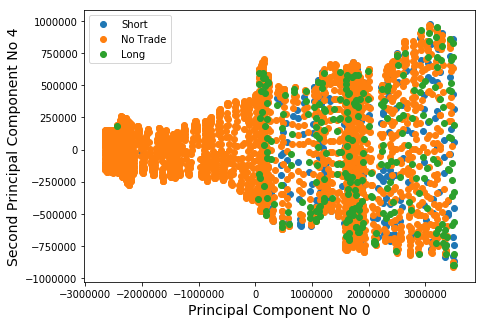

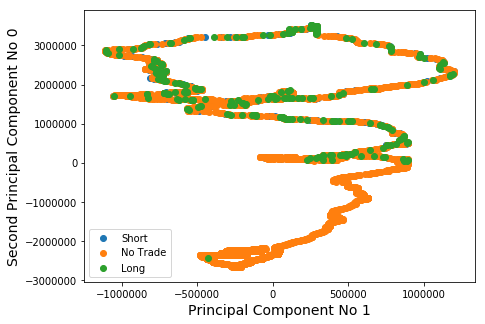

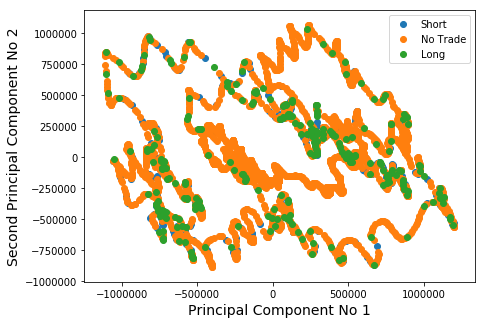

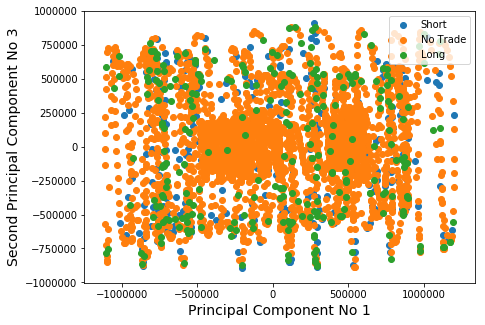

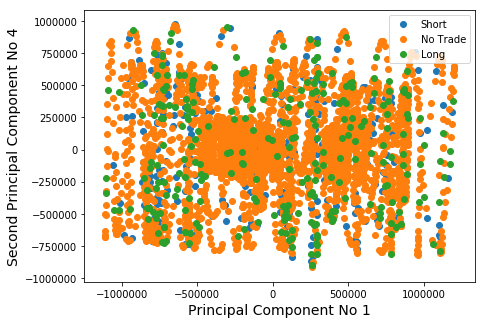

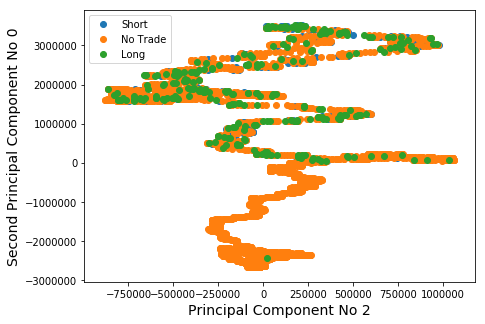

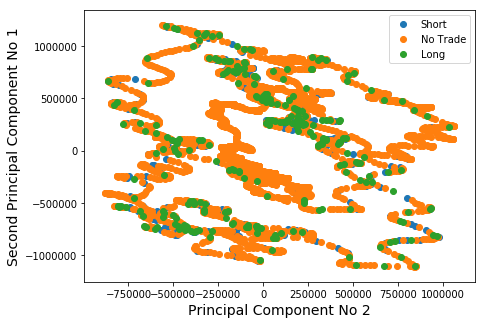

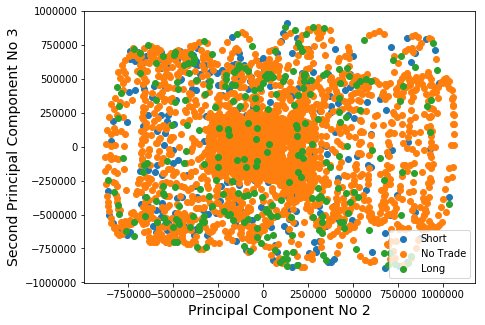

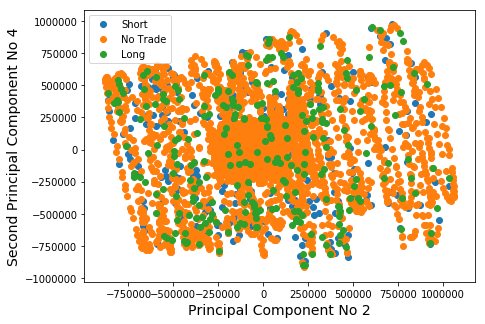

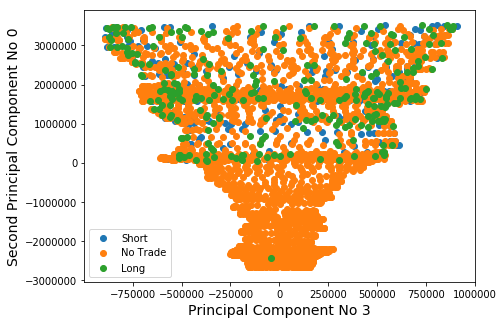

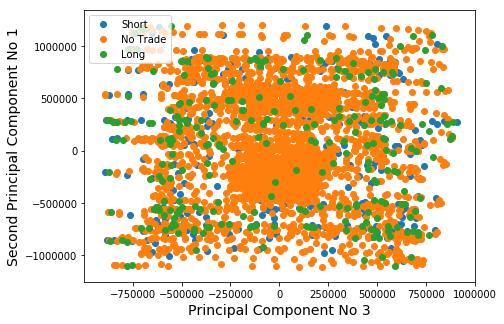

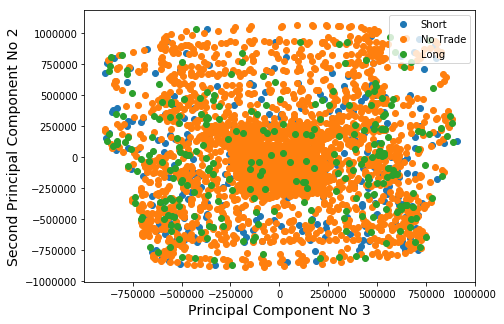

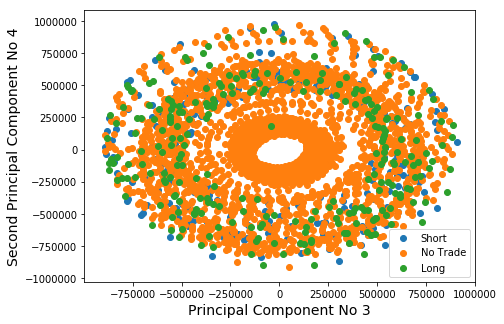

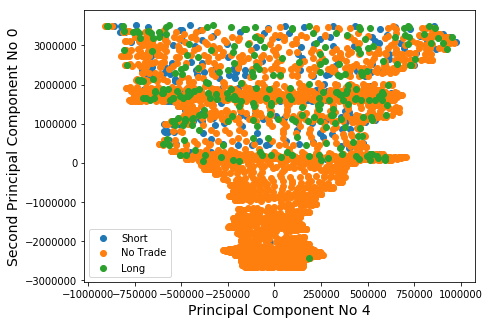

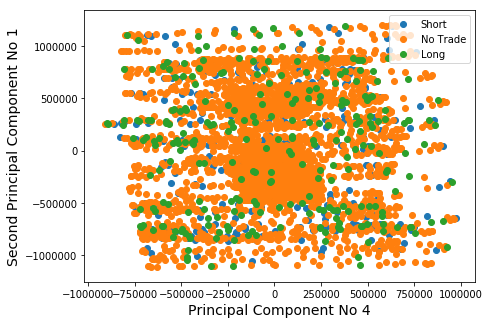

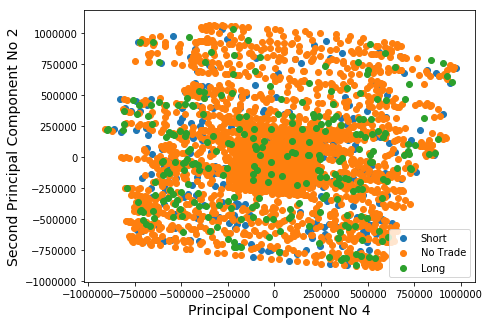

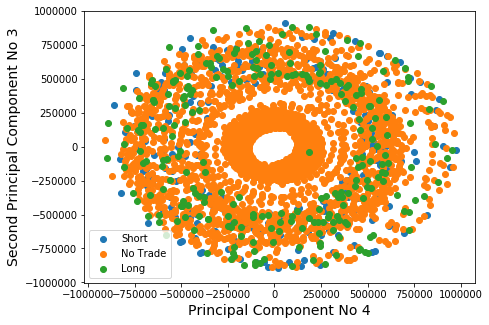

In [255]:
plot_pca_relation(gold_train_pca, 5, 5)

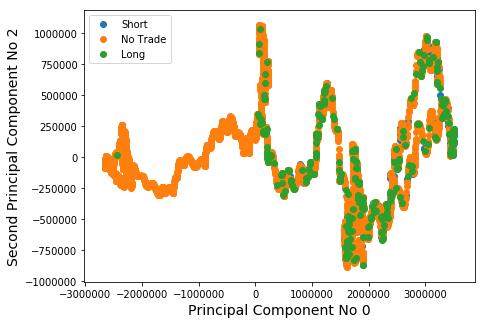

In [230]:
plot_pca_relation(gold_train_pca, 0, 2)

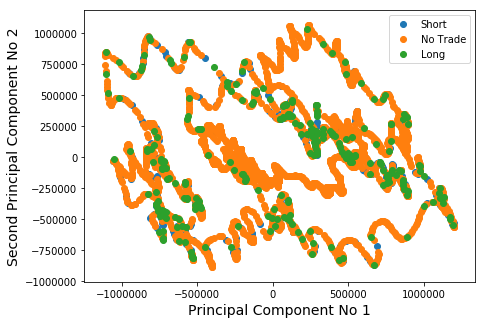

In [231]:
plot_pca_relation(gold_train_pca, 1, 2)

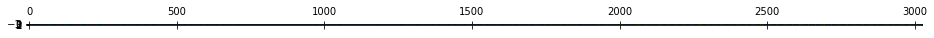

In [226]:
plt.matshow(pca.components_)
plt.show()

In [ ]:
feature_worst=list(cancer_df.columns[20:31])# select the 'worst' features
s=sns.heatmap(cancer_df[feature_worst].corr(),cmap='coolwarm') # fantastic tool to study the features 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
plt.show()

In [ ]:
print(type(gold_train), gold_train.shape)

In [ ]:
print(type(gold_train_trans.size))

In [ ]:
pca.components_

In [ ]:
gold = gold.loc[start_date:end_date]
corn = corn.loc[start_date:end_date]
coffee = coffee.loc[start_date:end_date]

In [ ]:
def add_cot(df, df_cot):
    for idx in df.index.values:
        mtrx = df_cot[df_cot.index < idx].values[:8]
        size = np.prod(mtrx.shape)
        mtrx = mtrx.reshape(size)
    return df